In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from skimage import io
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


In [2]:
# Define the directory containing the TIFF files
data_dir = r"C:\Users\ASUA\OneDrive - Institut Teknologi Bandung\Geo-X\Rock Lens\python\Dataset Final\REE-Granit"

# Collect all TIFF file paths from the directory
raster_fns = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.tif')]

# Print total arrays to be processed
print(f"Total arrays collected: {len(raster_fns)}")


Total arrays collected: 23


In [3]:
# Initialize a dictionary to store flattened grayscale arrays
data_dict = {}

# Loop through each TIFF file, convert to grayscale, and flatten
for tiff_file in raster_fns:
    try:
        # Read the TIFF file as grayscale
        grayscale_array = io.imread(tiff_file, as_gray=True)

        # Flatten the 2D array into 1D
        flattened_array = grayscale_array.flatten()

        # Store the flattened array with the filename as the key
        data_dict[os.path.basename(tiff_file)] = flattened_array

        print(f"{os.path.basename(tiff_file)} shape: {flattened_array.shape}")

    except Exception as e:
        print(f"Failed to process {tiff_file}: {e}")


<tifffile.TiffPage 0 @8> parsing GDAL_NODATA tag raised ValueError('-3.4028234663852886e+38 is not castable to float32')
<tifffile.TiffPage 0 @8> parsing GDAL_NODATA tag raised ValueError('-3.4028234663852886e+38 is not castable to float32')
<tifffile.TiffPage 0 @8> parsing GDAL_NODATA tag raised ValueError('-3.4028234663852886e+38 is not castable to float32')
<tifffile.TiffPage 0 @8> parsing GDAL_NODATA tag raised ValueError('-3.4028234663852886e+38 is not castable to float32')


Advance Argilic_kandite_lowres.tif shape: (1008382,)
Argilic-Sericite-Smectite_lowres.tif shape: (1008382,)
Carbonate_prophylitic.tif shape: (1008382,)
Demnas Merged.tif shape: (1008382,)
gravitigrd10000_rtp_250full_fix.tif shape: (1008382,)
magnetikgrd10000_rtp_250full_fix.tif shape: (1008382,)
NDVI_Lowres.tif shape: (1008382,)
Proximity_fault.tif shape: (1008382,)
REE.Ce_ppm.tif shape: (1008382,)
REE.Dy_ppm.tif shape: (1008382,)
REE.Er_ppm.tif shape: (1008382,)
REE.Eu_ppm.tif shape: (1008382,)
REE.Gd_ppm.tif shape: (1008382,)
REE.Ho_ppm.tif shape: (1008382,)
REE.La_ppm.tif shape: (1008382,)
REE.Lu_ppm.tif shape: (1008382,)
REE.Nd_ppm.tif shape: (1008382,)
REE.Pr_ppm.tif shape: (1008382,)
REE.Sm_ppm.tif shape: (1008382,)
REE.Tb_ppm.tif shape: (1008382,)
REE.Tm_ppm.tif shape: (1008382,)
REE.Yb_ppm.tif shape: (1008382,)
REE_labels.tif shape: (1008382,)


In [4]:
# Create a DataFrame from the dictionary
df = pd.DataFrame(data_dict)

# Remove ".tif" from column names for clarity
df.columns = [col.replace('.tif', '') for col in df.columns]

# Display the DataFrame shape and first few rows
print(f"DataFrame shape: {df.shape}")
print(df.head())


DataFrame shape: (1008382, 23)
   Advance Argilic_kandite_lowres  Argilic-Sericite-Smectite_lowres  \
0                        2.374147                          1.981707   
1                        2.264955                          1.993094   
2                        2.250363                          2.030109   
3                        2.336678                          2.019910   
4                        2.247231                          2.085587   

   Carbonate_prophylitic  Demnas Merged  gravitigrd10000_rtp_250full_fix  \
0          -3.402823e+38          691.0                              1.0   
1          -3.402823e+38          692.0                              1.0   
2          -3.402823e+38          691.0                              1.0   
3          -3.402823e+38          687.0                              1.0   
4          -3.402823e+38          689.0                              1.0   

   magnetikgrd10000_rtp_250full_fix  NDVI_Lowres  Proximity_fault  REE.Ce_ppm  \
0   

In [5]:
# Filter out rows with missing labels (unknown areas)
df_model = df[~df['REE_labels'].isna()]

# Define feature matrix and target variable
X = df_model.drop(columns=['REE_labels']).values  # Feature matrix
y = df_model['REE_labels'].values  # Target variable

# Define the full dataset (without labels) for prediction
X_full = df.drop(columns=['REE_labels']).values  # Full dataset for predictions

# Check shapes to ensure alignment
print(f"Training data shape: {X.shape}, Full data shape: {X_full.shape}")


Training data shape: (8445, 22), Full data shape: (1008382, 22)


In [6]:
# Separate features (X) and labels (Y)
Y = np.array(df_model.pop('REE_labels').values)
X = np.array(df_model)

# Verify shapes
print(f"Features shape: {X.shape}, Labels shape: {Y.shape}")


Features shape: (8445, 22), Labels shape: (8445,)


In [7]:
# Split the data (75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.6, random_state=42)



In [8]:
# Initialize individual classifiers
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svc_clf = SVC(probability=True, random_state=42)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

# Create a VotingClassifier with soft voting
voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('svc', svc_clf), ('mlp', mlp_clf)],
    voting='soft'
)

# Train the model using cross-validation
scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {scores.mean() * 100:.2f}%")

# Train the model on the full training data
voting_clf.fit(X_train, y_train)

# Evaluate on the test set
y_pred = voting_clf.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.2f}")

# Display classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Cross-Validation Accuracy: 97.84%
Test Accuracy: 100.00%
F1 Score: 1.00

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2295
         1.0       1.00      1.00      1.00      2772

    accuracy                           1.00      5067
   macro avg       1.00      1.00      1.00      5067
weighted avg       1.00      1.00      1.00      5067


Confusion Matrix:
 [[2295    0]
 [   0 2772]]


In [9]:
# Retrain the model on the full labeled dataset using the best parameters and algorithm
best_model = voting_clf  # Assuming the voting classifier performed best (replace if needed)

# Use all available labeled data (known areas) for training
X_full_train = (X)  # Fit-transform the entire feature matrix
best_model.fit(X_full_train, Y)  # Retrain the model on the entire labeled dataset

print("Model retrained on the full labeled dataset.")


Model retrained on the full labeled dataset.


In [10]:
import joblib
import h5py

# Simpan model menggunakan joblib dan HDF5
model_path = 'best_model_REE.h5'

# Buat sementara file joblib untuk menyimpan model
temp_model_path = 'temp_model.pkl'
joblib.dump(best_model, temp_model_path)  # Serialize and save the model

# Baca model sebagai binary dan simpan dalam HDF5
with open(temp_model_path, 'rb') as f:
    model_data = f.read()

with h5py.File(model_path, 'w') as hf:
    hf.create_dataset('model', data=np.void(model_data))  # Save in HDF5

print(f"Model saved as {model_path}")


Model saved as best_model_REE.h5


In [11]:
# Predict probabilities for the entire dataset (X_full)
y_prob_full = best_model.predict_proba(X_full)[:, 1]  # Probability of AOI (Class 1)

# Reshape probabilities back to the original raster shape
# Open a reference TIFF to get the shape
with rasterio.open(raster_fns[0]) as src:
    raster_shape = src.shape  # Extract the original raster shape (rows, cols)

# Ensure the probabilities are reshaped correctly into the original raster grid
probability_grid = y_prob_full.reshape(raster_shape)



Plot saved as 'Predicted_AOI_Probability_Map.png' with high resolution.


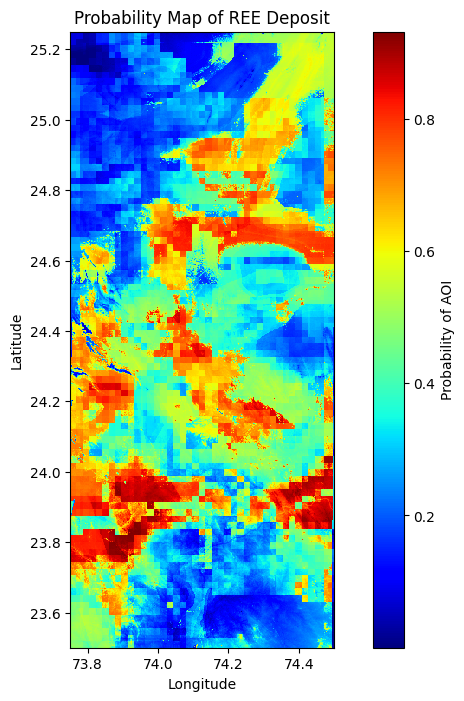

In [13]:
# Plot the probability map of Porphyry Deposit (Class 1)
plt.figure(figsize=(10, 8))
plt.imshow(probability_grid, cmap='jet', interpolation='nearest', extent=(
    src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top))
plt.colorbar(label='Probability of AOI')
plt.title('Probability Map of REE Deposit')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the figure with high resolution (before calling plt.show)
plt.savefig('Predicted_AOI_Probability_Map_REE.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

print("Plot saved as 'Predicted_AOI_Probability_Map.png' with high resolution.")

# Now display the plot
plt.show()
